In [14]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import pickle
import os
import json
import numpy as np
import pandas as pd 
import re 
import ast 
import dateutil.parser as dparser
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.formula.api as smf
import statsmodels.api as sm


# Helper functions 

In [23]:
def get_time_to_completion(telemetry_data):
    starts = [event for event in telemetry_data if event["event_type"] == "load_task"]
    ends = [
        event#["timestamp"]
        for event in telemetry_data
        if event["event_type"] == "submit_code" and event["completed_task"] == 1
    ]
    times_tasks_solved = []
    task_indices_seen = set()
    for start in starts:
        if start["task_index"] == -1 or start["task_index"] in task_indices_seen:
            continue
        task_indices_seen.add(start["task_index"])
        
        for end in ends:
            if end["task_index"] == start["task_index"]:
                # check if tim is more than 10mins
                if (end["timestamp"] - start["timestamp"]) / 1000 < 1800:
                    times_tasks_solved.append((end["timestamp"] - start["timestamp"]) / 1000)
                    break


    if len(times_tasks_solved) == 0:
        return [], np.nan
    return times_tasks_solved, np.mean(times_tasks_solved)


def get_coding_time(telemetry_data):
    # Get first load task
    start = [event["timestamp"] for event in telemetry_data if event["event_type"] == "load_task"][0]

    # Get last telemetry event
    end = telemetry_data[-1]["timestamp"]

    return (end - start) / 1000

def get_time_verifying_suggestion(telemetry_data):
    # Get suggestions
    suggestions_shown = [event for event in telemetry_data if event["event_type"] == "suggestion_shown"]

    suggestions_reviewed = [
        event for event in telemetry_data if event["event_type"] == "reject" or event["event_type"] == "accept"
    ]

    # Create a hashmap for suggestion reviews.
    reviewed_hashmap = {}
    for event in suggestions_reviewed:
        reviewed_hashmap[event["suggestion_id"]] = event["timestamp"]

    # Create a hashmap for times to completion
    time_spent_verifying = {}
    for event in suggestions_shown:
        if event["suggestion_id"] in reviewed_hashmap:
            time_spent_verifying[event["suggestion_id"]] = (
                reviewed_hashmap[event["suggestion_id"]] - event["timestamp"]
            ) / 1000
        # else:
        #     print("No review found for suggestion: ", event["suggestion_id"])

    return time_spent_verifying


# Pre-processing

In [3]:
cred = credentials.Certificate("../codeinterface-85b5e-firebase-adminsdk-11q7e-837ba92a03.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

In [4]:
docs = db.collection('responses').get()

In [5]:
DICT_TOOL_USAGE = {"1":"Strongly Disagree","2":"Disagree", "3":"Neutral", "4":"Agree", "5":"Strongly Agree"}

In [29]:
df = (pd.DataFrame([x.to_dict() for x in docs])
     .dropna(subset=["telemetry_data", "completed_task_time", "date_performed"])
     .assign(completed_task_time = lambda x: [dparser.parse(re.sub("\s*\([^)]*\)", "", y), fuzzy=True) for y in x["completed_task_time"]])
     .assign(date_performed = lambda x: [dparser.parse(re.sub("\s*\([^)]*\)", "", y), fuzzy=True) for y in x["date_performed"]])
     .assign(task_duration = lambda x: x.completed_task_time - x.date_performed)
     .assign(model = lambda x: [re.match("[a-zA-Z]*_[a-zA-Z0-9]*", x)[0] if re.match("[a-zA-Z]*_[a-zA-Z0-9]*", str(x)) else "" for x in x["task_id"]])
     .assign(n_tasks_completed = lambda z: [len([x for x in y if x["event_type"] == "submit_code" and x["completed_task"] == 1 and x["task_index"] != -1]) for y in z["telemetry_data"]])
     .assign(n_tasks_attempted = lambda z: [len([x for x in y if x["event_type"] == "load_task"]) for y in z["telemetry_data"]])
     .assign(n_tasks_skipped = lambda z: [len([x for x in y if x["event_type"] == "skip_task"]) for y in z["telemetry_data"]])
      
     .assign(TLX_frustration = lambda x: x["frustration"].astype(int))
     .assign(TLX_performance = lambda x: x["performance"].astype(int))
     .assign(TLX_temporal_demand = lambda x: x["temporalDemand"].astype(int))
     .assign(TLX_physical_demand = lambda x: x["physicalDemand"].astype(int))
     .assign(TLX_effort = lambda x: x["effort"].astype(int))
     .assign(TLX_mental_demand = lambda x: x["mentalDemand"].astype(int))
     .assign(TLX_total_score = lambda x: x.filter(like="TLX").sum(axis=1) * 5)
      
     .assign(n_sugg_accepted = lambda z: [len([x for x in y if x["event_type"] == "accept"]) for y in z["telemetry_data"]])
     .assign(n_sugg_shown = lambda z: [len([x for x in y if x["event_type"] == "suggestion_shown" and x["suggestion"] != ""]) for y in z["telemetry_data"]])
     .assign(sugg_accept_rate = lambda x: x.n_sugg_accepted / x.n_sugg_shown)
     .assign(task_completion_durations = lambda x: [get_time_to_completion(y)[0] for y in x['telemetry_data']])
     .assign(mean_task_duration = lambda x: [np.nanmean(y) for y in x.task_completion_durations])
     .assign(coding_time = lambda x: [get_coding_time(y) for y in x['telemetry_data']])
     .assign(time_spent_verifying = lambda x: [get_time_verifying_suggestion(y) for y in x['telemetry_data']]))

/var/folders/t5/pjvp_tpd6tl9tzz8k2kx6hd80000gq/T/ipykernel_77911/650013429.py:23: RuntimeWarning: Mean of empty slice
  .assign(mean_task_duration = lambda x: [np.nanmean(y) for y in x.task_completion_durations])


In [30]:
df = df.query("n_tasks_completed >= 1").reset_index()

In [31]:
df.loc[["model" in x for x in df["model"]], "model"] = "nomodel"

In [19]:
smf.ols("n_tasks_completed ~ model", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      n_tasks_completed   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.237
Date:                Mon, 12 Feb 2024   Prob (F-statistic):              0.289
Time:                        22:25:38   Log-Likelihood:                -417.79
No. Observations:                 213   AIC:                             849.6
Df Residuals:                     206   BIC:                             873.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         2.6389      0.292      9.051      0.000       2.064       3.214
model[T.autocomplete_llama34]    -0.3697      0.450     -0.821      0.413      -1.257       0.518
model[T.autocomplete_llama7]     -0.2579      0.480     -0.537      0.592      -1.205       0.689
model[T.chat_gpt35]               0.3085      0.407      0.758      0.449      -0.494       1.111
model[T.chat_llama34]            -0.3697      0.450     -0.821      0.413      -1.257       0.518
model[T.chat_llama7]             -0.7389      0.432     -1.709      0.089      -1.591       0.114
model[T.nomodel]              -3.605e-15      0.412  -8.74e-15      1.000      -0.813       0.813
==============================================================================
Omnibus:                       10.335   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               11.048
Skew:                           0.547   Prob(JB):                      0.00399
Kurtosis:                       2.777   Cond. No.                         7.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Sanity checks
* Add more after discussing data structure with Hussein 

In [148]:
# This is failing ... what are these durations exactly? Are we comparing the right values?  
assert all(np.array([len(x) for x in df["task_completion_durations"]]) == df["n_tasks_completed"])

AssertionError: 

# Visualizations

In [20]:
df.groupby("model")["n_tasks_completed"].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
autocomplete_gpt35,30.0,2.700000,2.167948,0.0,1.00,2.5,4.00,7.0
autocomplete_llama34,24.0,2.416667,1.471960,0.0,1.75,2.0,3.00,6.0
autocomplete_llama7,19.0,2.421053,1.923994,0.0,1.00,2.0,3.50,7.0
chat_gpt35,26.0,2.500000,1.860108,0.0,1.00,2.0,3.75,7.0
chat_llama34,22.0,2.363636,1.398824,0.0,2.00,2.0,3.00,6.0
chat_llama7,25.0,1.920000,1.351542,0.0,1.00,2.0,2.00,5.0
nomodel_0,9.0,3.000000,1.658312,1.0,2.00,3.0,3.00,6.0
nomodel_1,5.0,3.800000,1.923538,1.0,3.00,4.0,5.00,6.0
nomodel_2,9.0,1.666667,1.118034,0.0,1.00,2.0,2.00,3.0


In [21]:
df.filter(regex="TLX|model").groupby("model").describe()

TLX_frustration                                         \
                               count       mean       std  min    25%   50%   
model                                                                         
autocomplete_gpt35              30.0  10.600000  6.201223  2.0   4.25  13.0   
autocomplete_llama34            24.0  14.125000  5.110199  2.0  11.75  15.0   
autocomplete_llama7             19.0  11.368421  5.880387  2.0   5.50  12.0   
chat_gpt35                      26.0   9.076923  5.328588  2.0   4.00   9.5   
chat_llama34                    22.0  11.318182  5.454455  2.0   8.00  12.5   
chat_llama7                     25.0  10.200000  6.264982  2.0   3.00  11.0   
nomodel_0                        9.0   7.555556  5.502525  2.0   4.00   5.0   
nomodel_1                        5.0   6.200000  4.919350  2.0   2.00   4.0   
nomodel_2                        9.0  10.666667  5.830952  4.0   6.00  11.0   
nomodel_3                        3.0   8.666667  6.506407  2.0   5.50   9.0   
nomodel_4                        2.0  12.500000  6.363961  8.0  10.25  12.5   

                                  TLX_performance             ...  \
                        75%   max           count       mean  ...   
model                                                         ...   
autocomplete_gpt35    15.75  20.0            30.0   8.766667  ...   
autocomplete_llama34  19.00  20.0            24.0   7.791667  ...   
autocomplete_llama7   15.50  19.0            19.0   6.894737  ...   
chat_gpt35            13.75  20.0            26.0   8.538462  ...   
chat_llama34          14.75  20.0            22.0   7.909091  ...   
chat_llama7           15.00  20.0            25.0   8.600000  ...   
nomodel_0             11.00  16.0             9.0   8.444444  ...   
nomodel_1             11.00  12.0             5.0  12.600000  ...   
nomodel_2             15.00  20.0             9.0   4.666667  ...   
nomodel_3             12.00  15.0             3.0   3.333333  ...   
nomodel_4             14.75  17.0             2.0  11.000000  ...   

                     TLX_mental_demand       TLX_total_score              \
                                   75%   max           count        mean   
model                                                                      
autocomplete_gpt35                15.0  20.0            30.0  298.833333   
autocomplete_llama34              13.5  16.0            24.0  306.875000   
autocomplete_llama7               16.0  20.0            19.0  311.578947   
chat_gpt35                        14.0  18.0            26.0  304.807692   
chat_llama34                      16.0  20.0            22.0  308.636364   
chat_llama7                       17.0  20.0            25.0  318.200000   
nomodel_0                         15.0  20.0             9.0  290.555556   
nomodel_1                         15.0  18.0             5.0  303.000000   
nomodel_2                         16.0  20.0             9.0  317.777778   
nomodel_3                         15.0  15.0             3.0  276.666667   
nomodel_4                          9.0  11.0             2.0  345.000000   

                                                                      
                             std    min    25%    50%     75%    max  
model                                                                 
autocomplete_gpt35     89.574505  135.0  252.5  297.5  361.25  455.0  
autocomplete_llama34   89.743748  120.0  252.5  330.0  372.50  430.0  
autocomplete_llama7    67.145212  200.0  267.5  315.0  365.00  435.0  
chat_gpt35             73.163936  175.0  265.0  300.0  330.00  455.0  
chat_llama34           84.348791  140.0  252.5  302.5  358.75  490.0  
chat_llama7           119.372317   60.0  270.0  295.0  425.00  495.0  
nomodel_0              83.943599  195.0  230.0  290.0  340.00  440.0  
nomodel_1              91.419363  140.0  335.0  340.0  345.00  355.0  
nomodel_2             111.834451  150.0  290.0  325.0  370.00  525.0  
nomodel_3             165.4035

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'autocomplete_gpt35'),
  Text(1, 0, 'autocomplete_llama34'),
  Text(2, 0, 'autocomplete_llama7'),
  Text(3, 0, 'chat_gpt35'),
  Text(4, 0, 'chat_llama34'),
  Text(5, 0, 'chat_llama7'),
  Text(6, 0, 'nomodel')])

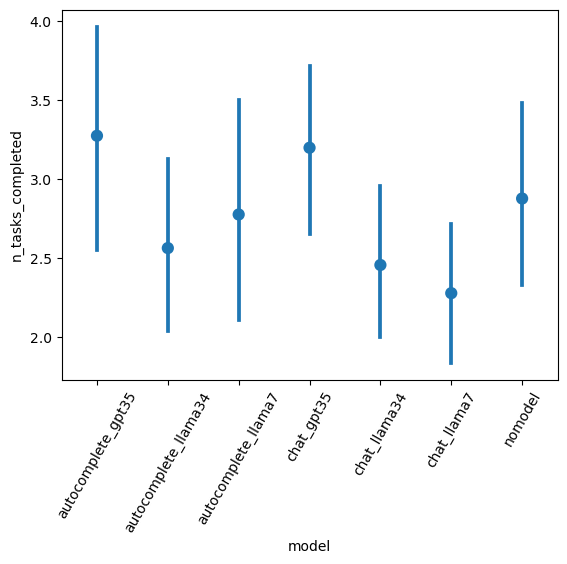

In [35]:
sns.pointplot(x="model", y="n_tasks_completed", data=df, linestyles="")
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'autocomplete_gpt35'),
  Text(1, 0, 'autocomplete_llama34'),
  Text(2, 0, 'autocomplete_llama7'),
  Text(3, 0, 'chat_gpt35'),
  Text(4, 0, 'chat_llama34'),
  Text(5, 0, 'chat_llama7'),
  Text(6, 0, 'nomodel')])

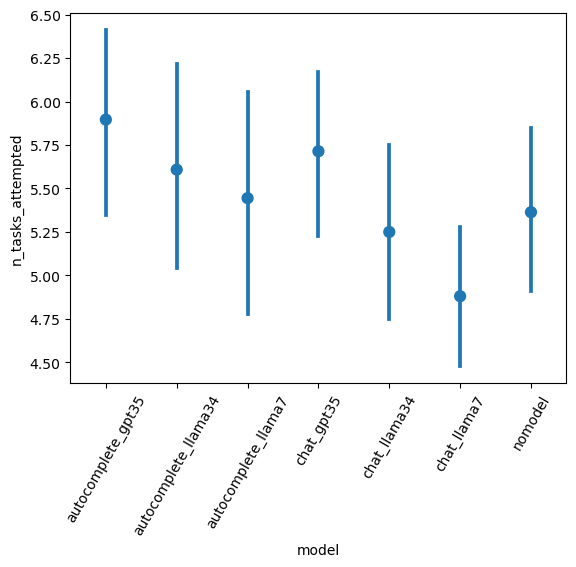

In [34]:
sns.pointplot(x="model", y="n_tasks_attempted", data=df, linestyles="")
plt.xticks(rotation=60)

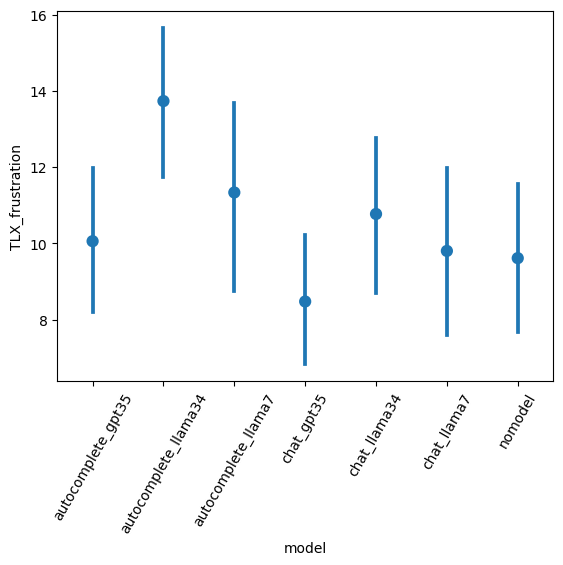

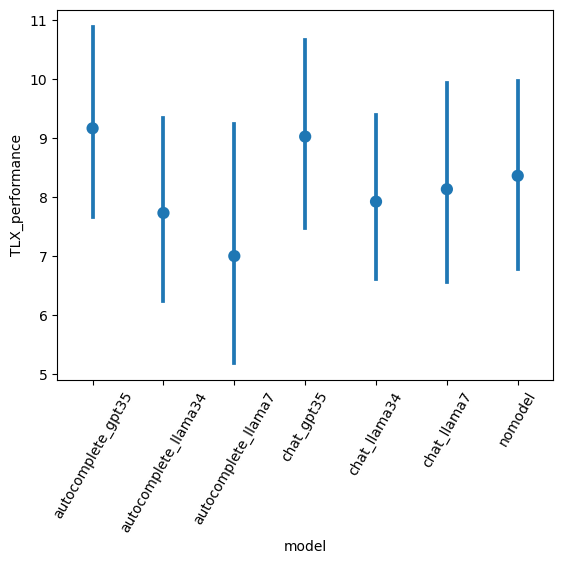

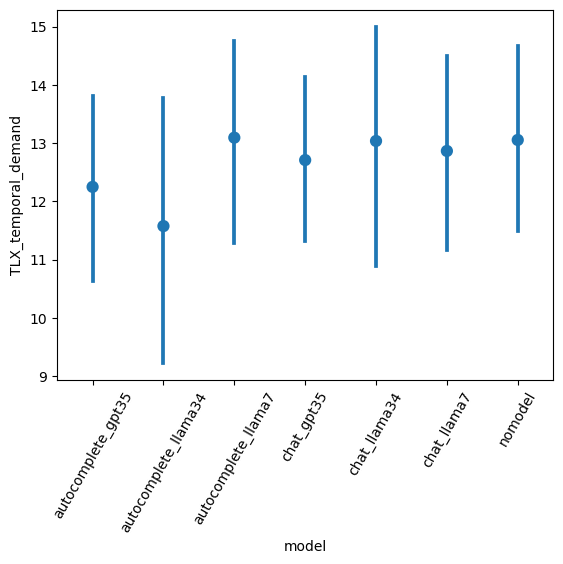

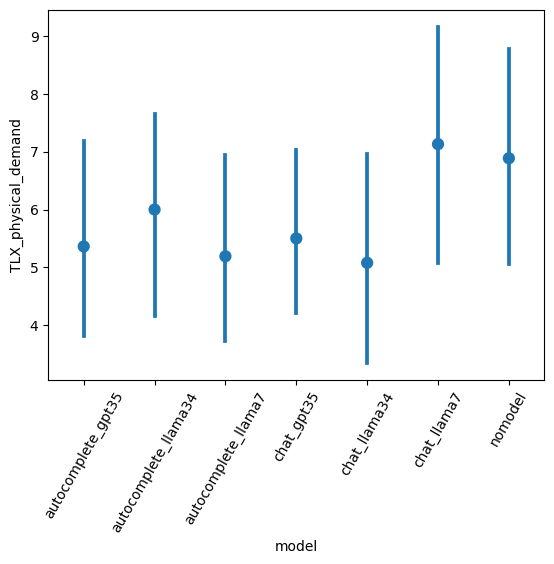

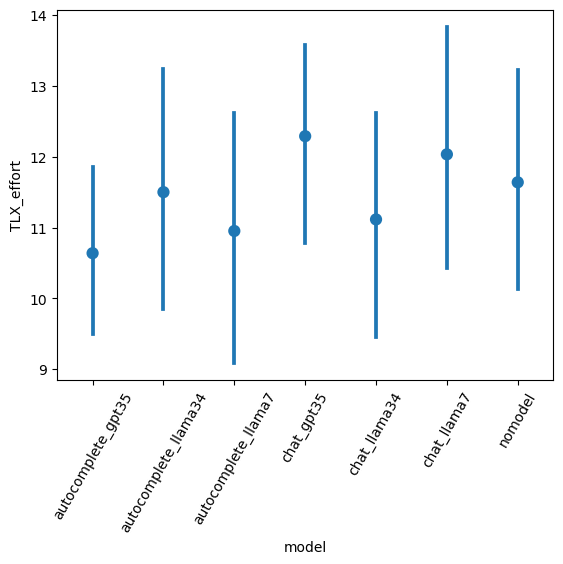

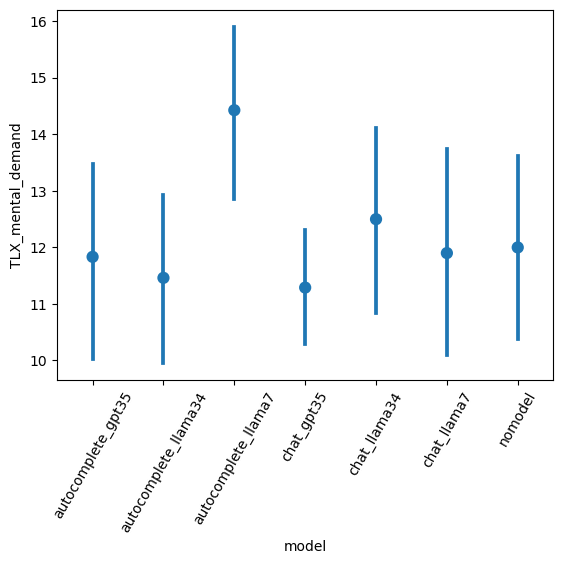

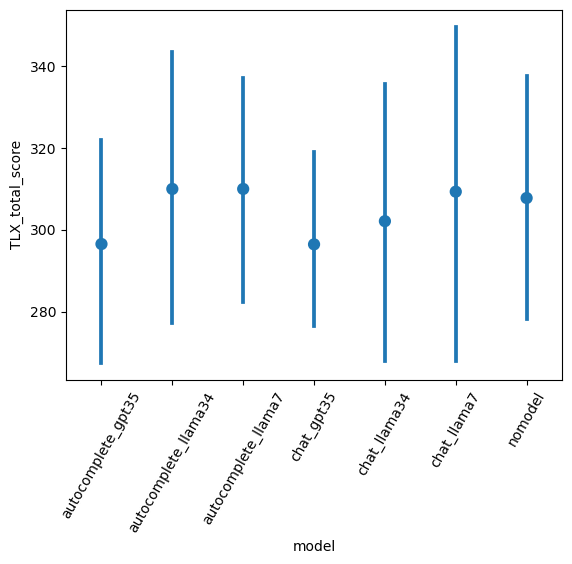

In [10]:
for tlx_col in df.filter(regex="TLX").columns:
    sns.pointplot(x="model", y=tlx_col, data=df, linestyles="")
    plt.xticks(rotation=60)
    plt.show()

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'autocomplete_gpt35'),
  Text(1, 0, 'autocomplete_llama34'),
  Text(2, 0, 'autocomplete_llama7'),
  Text(3, 0, 'chat_gpt35'),
  Text(4, 0, 'chat_llama34'),
  Text(5, 0, 'chat_llama7'),
  Text(6, 0, 'nomodel')])

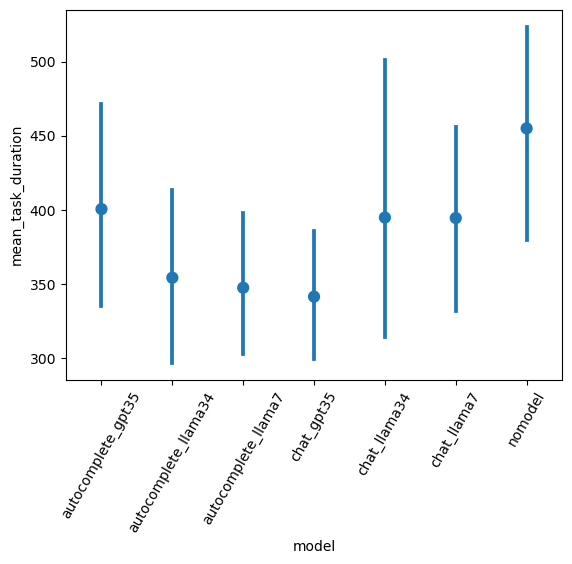

In [32]:
sns.pointplot(x="model", y="mean_task_duration", data=df, linestyles="")
plt.xticks(rotation=60)

In [39]:
smf.ols("mean_task_duration_mins ~ C(model, Treatment(reference='nomodel'))", data=df.assign(mean_task_duration_mins = lambda x: x.mean_task_duration/60)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     mean_task_duration_mins   R-squared:                       0.048
Model:                                 OLS   Adj. R-squared:                  0.017
Method:                      Least Squares   F-statistic:                     1.529
Date:                     Mon, 12 Feb 2024   Prob (F-statistic):              0.171
Time:                             22:38:13   Log-Likelihood:                -463.34
No. Observations:                      187   AIC:                             940.7
Df Residuals:                          180   BIC:                             963.3
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            7.5831      0.512     14.824      0.000       6.574       8.592
C(model, Treatment(reference='nomodel'))[T.autocomplete_gpt35]      -0.9062      0.748     -1.212      0.227      -2.382       0.570
C(model, Treatment(reference='nomodel'))[T.autocomplete_llama34]    -1.6767      0.798     -2.101      0.037      -3.252      -0.102
C(model, Treatment(reference='nomodel'))[T.autocomplete_llama7]     -1.7890      0.861     -2.078      0.039      -3.488      -0.090
C(model, Treatment(reference='nomodel'))[T.chat_gpt35]              -1.8891      0.713     -2.649      0.009      -3.296      -0.482
C(model, Treatment(reference='nomodel'))[T.chat_llama34]            -1.0013      0.788     -1.270      0.206      -2.557       0.554
C(model, Treatment(reference='nomodel'))[T.chat_llama7]             -1.0068      0.779     -1.292      0.198      -2.544       0.531
==============================================================================
Omnibus:                       46.445   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.665
Skew:                           1.172   Prob(JB):                     7.55e-21
Kurtosis:                       5.530   Cond. No.                         7.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
smf.ols("mean_task_duration ~ has_model", data=df.assign(has_model = lambda x: x.model == 'nomodel')).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     mean_task_duration   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     6.044
Date:                Mon, 12 Feb 2024   Prob (F-statistic):             0.0149
Time:                        22:45:18   Log-Likelihood:                -1230.6
No. Observations:                 187   AIC:                             2465.
Df Residuals:                     185   BIC:                             2472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           372.2487     14.138     26.330      0.000     344.356     400.141
has_model[T.True]    82.7385     33.655      2.458      0.015      16.341     149.136
==============================================================================
Omnibus:                       50.672   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.520
Skew:                           1.247   Prob(JB):                     4.49e-24
Kurtosis:                       5.754   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
smf.ols("mean_task_duration ~ model", data=df.assign(mean_task_duration_mins = lambda x: mean_task_duration/60)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     mean_task_duration   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.529
Date:                Mon, 12 Feb 2024   Prob (F-statistic):              0.171
Time:                        22:35:16   Log-Likelihood:                -1229.0
No. Observations:                 187   AIC:                             2472.
Df Residuals:                     180   BIC:                             2495.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       400.6168     32.740     12.236      0.000     336.012     465.221
model[T.autocomplete_llama34]   -46.2296     49.229     -0.939      0.349    -143.370      50.911
model[T.autocomplete_llama7]    -52.9714     52.905     -1.001      0.318    -157.365      51.422
model[T.chat_gpt35]             -58.9736     44.273     -1.332      0.185    -146.335      28.387
model[T.chat_llama34]            -5.7063     48.654     -0.117      0.907    -101.711      90.299
model[T.chat_llama7]             -6.0360     48.118     -0.125      0.900    -100.985      88.913
model[T.nomodel]                 54.3704     44.877      1.212      0.227     -34.182     142.923
==============================================================================
Omnibus:                       46.445   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.665
Skew:                           1.172   Prob(JB):                     7.55e-21
Kurtosis:                       5.530   Cond. No.                         7.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='model', ylabel='sugg_accept_rate'>

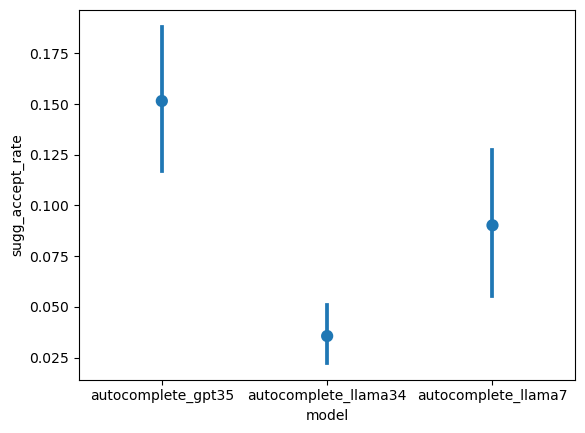

In [33]:
sns.pointplot(x="model", y="sugg_accept_rate", data=df.dropna(subset=["sugg_accept_rate"]), linestyles="")

# Regressions 

In [15]:
sm.stats.anova_lm(smf.ols("sugg_accept_rate ~ model", data=df).fit(), typ=2)

/Users/mosobay/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 2
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
model,0.550918,6.0,8.099833,0.000647
Residual,0.861536,76.0,NaN,NaN


In [16]:
smf.ols("sugg_accept_rate ~ model", data=df).fit().summary()

/Users/mosobay/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       sugg_accept_rate   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     8.100
Date:                Mon, 12 Feb 2024   Prob (F-statistic):           0.000647
Time:                        19:39:46   Log-Likelihood:                 66.384
No. Observations:                  79   AIC:                            -126.8
Df Residuals:                      76   BIC:                            -119.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.1562      0.018      8.679      0.000       0.120       0.192
model[T.autocomplete_llama34]    -0.1107      0.028     -3.971      0.000      -0.166      -0.055
model[T.autocomplete_llama7]     -0.0646      0.030     -2.129      0.037      -0.125      -0.004
model[T.chat_gpt35]                    0          0        nan        nan           0           0
model[T.chat_llama34]                  0          0        nan        nan           0           0
model[T.chat_llama7]                   0          0        nan        nan           0           0
model[T.nomodel]                       0          0        nan        nan           0           0
==============================================================================
Omnibus:                       58.218   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.524
Skew:                           2.185   Prob(JB):                     7.57e-72
Kurtosis:                      11.966   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# OLD CODE

In [116]:
docs = db.collection('responses').get()
# save docs in a pickle file called old_tasks.pkl
responses = {}
all_responses = {}
done_count = 0
for doc in docs:
    doc_dict = doc.to_dict()
    doc_dict['id'] = doc.id 
    all_responses[doc.id] = doc_dict
    if 'entered_exit_survey' and 'finalcomments'  in doc_dict:
        print(doc_dict['entered_exit_survey'])
        responses[doc.id] = doc_dict

        done_count += 1
        print(doc_dict['finalcomments'])
        print(doc_dict['howaiimproved'])



print(done_count)

Sun Jan 28 2024 20:34:44 GMT-0500 (Eastern Standard Time)

It could be more contextualized to the problem at hand, and it could also integrate correct documentation.
Mon Jan 29 2024 22:46:07 GMT-0800 (Pacific Standard Time)
The feedback aspect was very poor. The output section for the code was very small 2 lines so I had to scroll to see my outputs and the error messages were difficult to parse. It would show me a assertion error but since it was pure text, I had a hard time seeing what was the correct output and what my output was. The question was sometimes hard. For the transforming dataframe part, the example shown was very out of shape and the rows and columns were not in line making it hard to read the dataframe.
I wish I could prompt the AI to what I want to do, for example: If I make a comment in the program starting with AI like this, "#AI What is the syntax for making a string upper case?" Then the AI would answer this prompt with a comment. Another way AI could be improved i

In [ ]:
pickle.dump(all_responses, open('responses.pkl', 'wb'))

In [117]:
import dateutil.parser as dparser


def process_log(study_data, type = "none"):
    frustration = int(study_data["frustration"])
    performance = int(study_data["performance"])
    temporal_demand = int(study_data["temporalDemand"])
    physical_demand = int(study_data["physicalDemand"])
    effort = int(study_data["effort"])
    mental_demand = int(study_data["mentalDemand"])
    tlx_score = get_tlx_score(frustration, performance, temporal_demand, physical_demand, effort, mental_demand)
    #print("TLX Score: ", tlx_score)


    completed_time = dparser.parse(study_data["completed_task_time"], fuzzy=True)
    date_performed = dparser.parse(study_data["date_performed"], fuzzy=True)
    study_completion = get_completion_time(date_performed, completed_time)
    #print("Completion Time: ", study_completion)


    tasks_completed = get_tasks_completed(study_data["telemetry_data"])
    #print("Tasks Completed: ", tasks_completed)

    tasks_attempted = get_tasks_attempted(study_data["telemetry_data"])
    #print("Tasks Attempted: ", tasks_attempted)

    time_to_completion, avg_time_to_completion = get_time_to_completion(study_data["telemetry_data"])
    #print("Time To Completion: ", time_to_completion)
    #print("Average Time To Completion: ", avg_time_to_completion)

    tasks_skipped = get_tasks_skipped(study_data["telemetry_data"])
    #print("Tasks Skipped: ", tasks_skipped)

    coding_time = get_coding_time(study_data["telemetry_data"])
    #print("Coding Time: ", coding_time)
    additional_metrics = {}
    if type == "autocomplete":
        accept_rate = get_suggestion_acceptance_rate(study_data["telemetry_data"])
        additional_metrics = {
            "accept_rate": accept_rate,
        }
    
    if type == "chat":
        # count 'assistant_response', 'copy_code' event types in telemetry_data
        assistant_response_count = len([event for event in study_data["telemetry_data"] if event["event_type"] == "assistant_response"])
        copy_code_count = len([event for event in study_data["telemetry_data"] if event["event_type"] == "copy_code"])
        paste_into_editor_count = len([event for event in study_data["telemetry_data"] if event["event_type"] == "paste_into_editor"])
        additional_metrics = {
            "assistant_response_count": assistant_response_count,
            "copy_code_count": copy_code_count,
            "paste_into_editor_count": paste_into_editor_count,
        }
    	
    if type == "chat" or type == "autocomplete":
        # aihelpful 
        aihelpful = int(study_data["aihelpful"])
        additional_metrics["aihelpful"] = aihelpful

    dict_metrics  = {

        "tlx_score": tlx_score,
        "study_completion": study_completion,
        "tasks_completed": tasks_completed,
        "tasks_attempted": tasks_attempted,
        "time_to_completion": time_to_completion,
        "avg_time_to_completion": avg_time_to_completion,
        "tasks_skipped": tasks_skipped,
        "coding_time": coding_time,
        **additional_metrics
    }
    return dict_metrics

def get_tlx_score(frustration, performance, temporal_demand, physical_demand, effort, mental_demand):
    return (frustration + performance + temporal_demand + physical_demand + effort + mental_demand) * 5


def convert_tool_usage_to_str(tool_usage):
    if tool_usage == "1":
        return "Strongly Disagree"
    elif tool_usage == "2":
        return "Disagree"
    elif tool_usage == "3":
        return "Neutral"
    elif tool_usage == "4":
        return "Agree"
    elif tool_usage == "5":
        return "Strongly Agree"
    else:
        raise ValueError("Invalid tool usage")


def get_completion_time(start_time, end_time):
    return end_time - start_time


def get_suggestion_acceptance_rate(telemetry_data):
    num_accept = len([event for event in telemetry_data if event["event_type"] == "accept"])
    # only count suggestion_shown when suggestion is not ""
    num_suggestion_shown = len([event for event in telemetry_data if event["event_type"] == "suggestion_shown" and event["suggestion"] != ""])
    # if num_suggestion_shown == 0:
    #     print("No suggestions shown!!")
    #     return np.nan
    
    return num_accept / num_suggestion_shown


def get_tasks_completed(telemetry_data):
    return len(
        [event for event in telemetry_data if event["event_type"] == "submit_code" and event["completed_task"] == 1 and event["task_index"] != -1]
    )


def get_tasks_attempted(telemetry_data):
    return len([event for event in telemetry_data if event["event_type"] == "load_task"])


def get_time_to_completion(telemetry_data):
    starts = [event for event in telemetry_data if event["event_type"] == "load_task"]
    ends = [
        event#["timestamp"]
        for event in telemetry_data
        if event["event_type"] == "submit_code" and event["completed_task"] == 1
    ]
    times_tasks_solved = []
    task_indices_seen = set()
    for start in starts:
        if start["task_index"] == -1 or start["task_index"] in task_indices_seen:
            continue
        task_indices_seen.add(start["task_index"])
        
        for end in ends:
            if end["task_index"] == start["task_index"]:
                # check if tim is more than 10mins
                if (end["timestamp"] - start["timestamp"]) / 1000 < 600:
                    times_tasks_solved.append((end["timestamp"] - start["timestamp"]) / 1000)
                    break


    if len(times_tasks_solved) == 0:
        return 0, np.nan
    return times_tasks_solved, np.mean(times_tasks_solved)


def get_coding_time(telemetry_data):
    # Get first load task
    start = [event["timestamp"] for event in telemetry_data if event["event_type"] == "load_task"][0]

    # Get last telemetry event
    end = telemetry_data[-1]["timestamp"]

    return (end - start) / 1000


def get_tasks_skipped(telemetry_data):
    return len([event for event in telemetry_data if event["event_type"] == "skip_task"])


def get_tasks_skipped(telemetry_data):
    return len([event for event in telemetry_data if event["event_type"] == "skip_task"])


def get_time_verifying_suggestion(telemetry_data):
    # Get suggestions
    suggestions_shown = [event for event in telemetry_data if event["event_type"] == "suggestion_shown"]

    suggestions_reviewed = [
        event for event in telemetry_data if event["event_type"] == "reject" or event["event_type"] == "accept"
    ]

    # Create a hashmap for suggestion reviews.
    reviewed_hashmap = {}
    for event in suggestions_reviewed:
        reviewed_hashmap[event["suggestion_id"]] = event["timestamp"]

    # Create a hashmap for times to completion
    time_spent_verifying = {}
    for event in suggestions_shown:
        if event["suggestion_id"] in reviewed_hashmap:
            time_spent_verifying[event["suggestion_id"]] = (
                reviewed_hashmap[event["suggestion_id"]] - event["timestamp"]
            ) / 1000
        else:
            print("No review found for suggestion: ", event["suggestion_id"])

    return time_spent_verifying


In [118]:
autoocomplete_gpt35_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'accept_rate': [], 'aihelpful': []}
autocomplete_llama34_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'accept_rate': [], 'aihelpful': []}
autocomplete_llama7_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'accept_rate': [], 'aihelpful': []}
chat_gpt35_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'assistant_response_count': [], 'copy_code_count': [], 'paste_into_editor_count': [],  'aihelpful': []}
chat_llama34_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'assistant_response_count': [], 'copy_code_count': [], 'paste_into_editor_count': [],  'aihelpful': []}
chat_llama7_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': [], 'assistant_response_count': [], 'copy_code_count': [], 'paste_into_editor_count': [],  'aihelpful': []}
nomodel_metrics = {'num_responses': 0, 'tlx_score': [], 'study_completion': [], 'tasks_completed': [], 'tasks_attempted': [], 'time_to_completion': [], 'avg_time_to_completion': [], 'tasks_skipped': [], 'coding_time': []}
for resp in responses.values():
    if 'entered_exit_survey' not in resp:
        continue
    resp_id = resp['id']
    print(resp_id)
    log_metrics = process_log(resp)
    if log_metrics['tasks_completed'] < 2:
        continue
    print(f'name {resp["name"]} email {resp["email"]} completed {log_metrics["tasks_completed"]} tasks')
    # get event types
    print(f'event types {set([event["event_type"] for event in resp["telemetry_data"]])}')
    if 'autocomplete_gpt35' in resp_id:
        autoocomplete_gpt35_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="autocomplete")
        # merge dicts
        for key in log_metrics:
            autoocomplete_gpt35_metrics[key].append(log_metrics[key])
        if log_metrics['accept_rate'] <0.001:
            print(f'never accepted sug for {resp_id} name {resp["name"]} email {resp["email"]}')
            
    elif 'autocomplete_llama34' in resp_id:
        autocomplete_llama34_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="autocomplete")
        for key in log_metrics:
            autocomplete_llama34_metrics[key].append(log_metrics[key])
        if log_metrics['accept_rate'] <0.001:
            print(f'never accepted sug for {resp_id} name {resp["name"]} email {resp["email"]}')
    elif 'autocomplete_llama7' in resp_id:
        autocomplete_llama7_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="autocomplete")
        for key in log_metrics:
            autocomplete_llama7_metrics[key].append(log_metrics[key])
        if log_metrics['accept_rate'] <0.001:
            print(f'never accepted sug for {resp_id} name {resp["name"]} email {resp["email"]}')
    elif 'chat_gpt35' in resp_id:
        chat_gpt35_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="chat")
        for key in log_metrics:
            chat_gpt35_metrics[key].append(log_metrics[key])
        if log_metrics['assistant_response_count'] < 1:
            print(f'never responded for {resp_id} name {resp["name"]} email {resp["email"]}')
            # print all events with type paste_into_editor
            for event in resp["telemetry_data"]:
                if event["event_type"] == "paste_into_editor":
                    print(event)
    elif 'chat_llama34' in resp_id:
        chat_llama34_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="chat")
        for key in log_metrics:
            chat_llama34_metrics[key].append(log_metrics[key])
        if log_metrics['assistant_response_count'] < 1:
            print(f'never responded for {resp_id} name {resp["name"]} email {resp["email"]}')
            for event in resp["telemetry_data"]:
                if event["event_type"] == "paste_into_editor":
                    print(event)
    elif 'chat_llama7' in resp_id:
        chat_llama7_metrics['num_responses'] += 1
        log_metrics = process_log(resp, type="chat")
        for key in log_metrics:
            chat_llama7_metrics[key].append(log_metrics[key])
        if log_metrics['assistant_response_count'] < 1:
            print(f'never responded for {resp_id} name {resp["name"]} email {resp["email"]}')
            for event in resp["telemetry_data"]:
                if event["event_type"] == "paste_into_editor":
                    print(event)
    elif 'nomodel' in resp_id:
        nomodel_metrics['num_responses'] += 1
        log_metrics = process_log(resp)
        for key in log_metrics:
            nomodel_metrics[key].append(log_metrics[key])
    else:
        print('no model found for response ' + resp_id)


autocomplete_gpt35_0_4-4767663
name Ming Chong Lim email mingchol@andrew.cmu.edu completed 7 tasks
event types {'before_shown', 'load_task', 'submit_code', 'suggestion_shown', 'request_suggestion', 'reject', 'save_code', 'accept', 'run_code'}
autocomplete_gpt35_0_9-263157
name San Shin email samshin0714@gmail.com completed 2 tasks
event types {'before_shown', 'load_task', 'submit_code', 'suggestion_shown', 'skip_task', 'request_suggestion', 'reject', 'save_code', 'code_reset', 'accept', 'run_code'}
autocomplete_gpt35_1_1-5457944
name Shrikara Varna email svarna@andrew.cmu.edu completed 3 tasks
event types {'before_shown', 'load_task', 'submit_code', 'suggestion_shown', 'skip_task', 'reject', 'save_code', 'accept', 'run_code'}
autocomplete_gpt35_1_10-7542461
name Nirajan Koirala email nkoirala@nd.edu completed 3 tasks
event types {'before_shown', 'load_task', 'submit_code', 'suggestion_shown', 'skip_task', 'reject', 'save_code', 'accept', 'run_code'}
autocomplete_gpt35_1_2-7342708
name 

In [119]:

# print metrics for each
print('autoocomplete_gpt35_metrics')
print(autoocomplete_gpt35_metrics)
print('autocomplete_llama34_metrics')
print(autocomplete_llama34_metrics)
print('autocomplete_llama7_metrics')
print(autocomplete_llama7_metrics)
print('chat_gpt35_metrics')
print(chat_gpt35_metrics)
print('chat_llama34_metrics')
print(chat_llama34_metrics)
print('chat_llama7_metrics')
print(chat_llama7_metrics)
print('nomodel_metrics')
print(nomodel_metrics)


autoocomplete_gpt35_metrics
{'num_responses': 9, 'tlx_score': [265, 260, 375, 380, 340, 135, 350, 455, 285], 'study_completion': [datetime.timedelta(seconds=2006), datetime.timedelta(seconds=3162), datetime.timedelta(seconds=2240), datetime.timedelta(seconds=2265), datetime.timedelta(seconds=2284), datetime.timedelta(seconds=2545), datetime.timedelta(seconds=2456), datetime.timedelta(seconds=2316), datetime.timedelta(seconds=1634)], 'tasks_completed': [7, 2, 3, 3, 6, 5, 2, 3, 7], 'tasks_attempted': [8, 6, 6, 6, 8, 7, 5, 6, 8], 'time_to_completion': [[134.873, 226.801, 269.65, 261.069, 146.12, 155.127, 558.661], [511.013, 45.36], [226.867, 208.59], [292.668, 528.917, 356.693], [146.457, 208.015, 273.293, 378.161, 319.032, 331.631], [127.053, 508.808, 386.152, 249.752, 244.011], [175.612], [262.154, 429.33], [88.23, 124.503, 304.871, 186.677, 319.081, 352.976, 65.946]], 'avg_time_to_completion': [250.32871428571428, 278.18649999999997, 217.7285, 392.75933333333336, 276.09816666666666, 30

In [120]:
# get average avg_time_to_completion and tasks_completed
print('avg_time_to_completion')
print('autocomplete_gpt35_metrics')
print(np.nanmean(autoocomplete_gpt35_metrics['avg_time_to_completion']))
print('autocomplete_llama34_metrics')
print(np.nanmean(autocomplete_llama34_metrics['avg_time_to_completion']))
print('autocomplete_llama7_metrics')
print(np.nanmean(autocomplete_llama7_metrics['avg_time_to_completion']))
print('chat_gpt35_metrics')
print(np.nanmean(chat_gpt35_metrics['avg_time_to_completion']))
print('chat_llama34_metrics')
print(np.nanmean(chat_llama34_metrics['avg_time_to_completion']))
print('chat_llama7_metrics')
print(np.nanmean(chat_llama7_metrics['avg_time_to_completion']))
print('nomodel_metrics')
print(np.nanmean(nomodel_metrics['avg_time_to_completion']))

print('tasks_completed')
print('autocomplete_gpt35_metrics')
print(np.nanmean(autoocomplete_gpt35_metrics['tasks_completed']))
print('autocomplete_llama34_metrics')
print(np.nanmean(autocomplete_llama34_metrics['tasks_completed']))
print('autocomplete_llama7_metrics')
print(np.nanmean(autocomplete_llama7_metrics['tasks_completed']))
print('chat_gpt35_metrics')
print(np.nanmean(chat_gpt35_metrics['tasks_completed']))
print('chat_llama34_metrics')
print(np.nanmean(chat_llama34_metrics['tasks_completed']))
print('chat_llama7_metrics')
print(np.nanmean(chat_llama7_metrics['tasks_completed']))
print('nomodel_metrics')
print(np.nanmean(nomodel_metrics['tasks_completed']))
print("tasks_skipped")
print('autocomplete_gpt35_metrics')
print(np.nanmean(autoocomplete_gpt35_metrics['tasks_skipped']))
print('autocomplete_llama34_metrics')
print(np.nanmean(autocomplete_llama34_metrics['tasks_skipped']))
print('autocomplete_llama7_metrics')
print(np.nanmean(autocomplete_llama7_metrics['tasks_skipped']))
print('chat_gpt35_metrics')
print(np.nanmean(chat_gpt35_metrics['tasks_skipped']))
print('chat_llama34_metrics')
print(np.nanmean(chat_llama34_metrics['tasks_skipped']))
print('chat_llama7_metrics')
print(np.nanmean(chat_llama7_metrics['tasks_skipped']))
print('nomodel_metrics')
print(np.nanmean(nomodel_metrics['tasks_skipped']))

print("aihelpful")
print('autocomplete_gpt35_metrics')
print(np.nanmean(autoocomplete_gpt35_metrics['aihelpful']))
print('autocomplete_llama34_metrics')
print(np.nanmean(autocomplete_llama34_metrics['aihelpful']))
print('autocomplete_llama7_metrics')
print(np.nanmean(autocomplete_llama7_metrics['aihelpful']))
print('chat_gpt35_metrics')
print(np.nanmean(chat_gpt35_metrics['aihelpful']))
print('chat_llama34_metrics')
print(np.nanmean(chat_llama34_metrics['aihelpful']))
print('chat_llama7_metrics')
print(np.nanmean(chat_llama7_metrics['aihelpful']))


avg_time_to_completion
autocomplete_gpt35_metrics
271.73899841269844
autocomplete_llama34_metrics
264.5228125
autocomplete_llama7_metrics
214.24385416666667
chat_gpt35_metrics
208.97562857142862
chat_llama34_metrics
316.08382666666665
chat_llama7_metrics
242.8976
nomodel_metrics
296.14387500000004
tasks_completed
autocomplete_gpt35_metrics
4.222222222222222
autocomplete_llama34_metrics
3.0
autocomplete_llama7_metrics
5.0
chat_gpt35_metrics
4.6
chat_llama34_metrics
3.4
chat_llama7_metrics
2.6
nomodel_metrics
3.6666666666666665
tasks_skipped
autocomplete_gpt35_metrics
0.6666666666666666
autocomplete_llama34_metrics
0.625
autocomplete_llama7_metrics
0.5
chat_gpt35_metrics
0.6
chat_llama34_metrics
0.8
chat_llama7_metrics
0.8
nomodel_metrics
0.16666666666666666
aihelpful
autocomplete_gpt35_metrics
2.6666666666666665
autocomplete_llama34_metrics
2.0
autocomplete_llama7_metrics
2.25
chat_gpt35_metrics
5.6
chat_llama34_metrics
5.2
chat_llama7_metrics
5.8
